In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import figure 

keras = tf.keras

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
x0 = [[0],[0]]
P0 = [[0, 0], [0, 0]]
dt = 0.1
sigma_a = 0.05
sigma_z = 0.1

#tf.reset_default_graph()

with tf.compat.v1.variable_scope('constants'):
    F = tf.constant([[1, dt],[0, 1]], dtype=tf.float32)
    G = tf.constant([[dt**2/2], [dt]], dtype=tf.float32)
    Q = tf.matmul(G, G, transpose_b=True) * sigma_a**2
    H = tf.constant([[1,0]], dtype=tf.float32)
    R = tf.constant(sigma_z**2, dtype=tf.float32)

with tf.compat.v1.variable_scope('model'):
    with tf.compat.v1.variable_scope('state'):
        x = tf.Variable(x0, dtype=tf.float32)
    
    with tf.compat.v1.variable_scope('noise'):
        w = G*tf.compat.v1.random_normal([1], mean=0, stddev=sigma_a)
        
    with tf.compat.v1.variable_scope('update_model'):
        update_model = x.assign(tf.matmul(F,x) + w)
    
with tf.compat.v1.variable_scope('observation'):
    v = tf.compat.v1.random_normal([1], mean=0, stddev=sigma_z)
    z = tf.matmul(H,x) + v

with tf.compat.v1.variable_scope('kalman_filter'):
    with tf.compat.v1.variable_scope('model_estimate'):
        xhat = tf.Variable(x0, dtype=tf.float32)
        P = tf.Variable(P0, dtype=tf.float32)

    with tf.compat.v1.variable_scope('predict'):
        predict_xhat = xhat.assign(tf.matmul(F,xhat))
        predict_P = P.assign(tf.matmul(F,tf.matmul(P,F, transpose_b=True)) + Q)
        
    with tf.compat.v1.variable_scope('update_estimation'):
        y1 = z - tf.matmul(H,xhat)
        S = R + tf.matmul(H,tf.matmul(P,H, transpose_b=True))
        K = tf.matmul(tf.matmul(P,H, transpose_b=True) , tf.linalg.inv(S))
        update_xhat = tf.compat.v1.assign_add(xhat, tf.matmul(K,y1))
        delta_P = tf.matmul(K,tf.matmul(H,P))
        update_P = tf.compat.v1.assign_sub(P, delta_P)
        y2 = z - tf.matmul(H,xhat)
    
with tf.compat.v1.Session() as sess:    
    sess.run(tf.compat.v1.global_variables_initializer())
    #summary_writer = tf.summary.FileWriter('logdir/', sess.graph)
    
    N = 200

    t = [i*dt for i in range(N)]
    model = np.array([x0]*N, dtype=np.float32)
    estimate1 = np.array([x0]*N, dtype=np.float32)
    error1 = np.array([P0]*N, dtype=np.float32)
    estimate2 = np.array([x0]*N, dtype=np.float32)
    error2 = np.array([P0]*N, dtype=np.float32)
    observations = np.array([0]*N, dtype=np.float32)
    for i in range(1,N):
        model[i], estimate1[i] , error1[i], estimate2[i], error2[i], observations[i] = sess.run([update_model, predict_xhat, predict_P, update_xhat, update_P, z])

#plot

plt.figure(num=None, figsize=(14, 6))

plt.subplot(1, 2, 1)

plt.fill_between(t,estimate2[:,0,0]+np.sqrt(error2[:,0,0]),estimate2[:,0,0]-np.sqrt(error2[:,0,0]), color = [0.5,0.75,0.75,.5])
plt.plot(t, model[:,0,0],  color='k', linewidth=2.0)
plt.plot(t, observations, color='r', marker='.', linestyle='None')

plt.ylabel('Position', fontsize=18)
plt.xlabel('Time', fontsize=18)

plt.subplot(1, 2, 2)
plt.fill_between(t,estimate2[:,1,0]+np.sqrt(error2[:,1,1]),estimate2[:,1,0]-np.sqrt(error2[:,1,1]), color = [0.5,0.75,0.75,.5])
plt.plot(t, model[:,1,0],  color='k', linewidth=2.0)

plt.ylabel('Velocity', fontsize=18)
plt.xlabel('Time', fontsize=18)

plt.savefig('simple.png')

TypeError: Fetch argument <tf.Variable 'UnreadVariable' shape=(2, 1) dtype=float32> has invalid type <class 'tensorflow.python.ops.resource_variable_ops._UnreadVariable'>, must be a string or Tensor. (Can not convert a _UnreadVariable into a Tensor or Operation.)

In [26]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
            (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

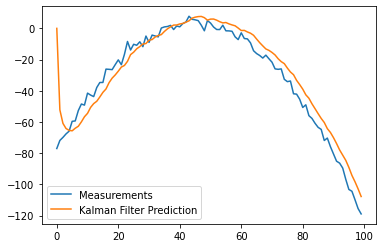

In [32]:
#def example():
dt = 1.0/60
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

x = np.linspace(-10, 10, 100)
measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)

kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []

for z in measurements:
    predictions.append(np.dot(H,  kf.predict())[0])
    kf.update(z)

import matplotlib.pyplot as plt
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

#if __name__ == '__main__':
    #example()

In [29]:
measurements

array([-7.37030949e+01, -7.47037469e+01, -7.03987620e+01, -6.71241331e+01,
       -5.94010880e+01, -6.05346992e+01, -5.66355996e+01, -5.96432004e+01,
       -5.04967745e+01, -5.04123670e+01, -4.63624507e+01, -4.14262172e+01,
       -3.88260244e+01, -3.64561149e+01, -3.77192533e+01, -3.26649765e+01,
       -3.29525751e+01, -2.66661283e+01, -2.56411667e+01, -2.46691128e+01,
       -2.23892989e+01, -1.94697617e+01, -1.80897838e+01, -1.72732216e+01,
       -1.42964544e+01, -1.66955869e+01, -1.40849917e+01, -8.80026098e+00,
       -7.66434983e+00, -3.64454039e+00, -3.98041854e+00, -6.90231695e+00,
       -5.27268919e+00, -7.67593168e-02, -4.34467958e+00,  1.21068713e+00,
        1.54503373e+00,  1.73107706e+00,  2.44652839e+00,  1.09035419e+00,
        5.98194353e+00,  3.85585172e+00,  3.07622913e+00,  1.97156223e-01,
        4.93013282e+00,  2.74933336e+00,  3.26220127e+00,  2.93503061e+00,
        4.52533873e+00,  3.47662507e+00,  2.74919725e+00,  1.75638038e+00,
       -4.24450995e-01,  

In [28]:
measurements.T.shape

(100,)